In [1]:
import numpy as np
from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy.table import Column
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.wcs import WCS
from astropy.io import fits

from matplotlib.colors import LogNorm

from astropy.utils.data import download_file

catalog_path='/Users/EvanB.LAPTOP-8CHCIOMA/Downloads/'

#A100-NSA Catalog
myTab=Table.read(catalog_path+'a100-nsa-for-adap.fits')

In [18]:
# Cut Sample

# SNR cut: GALEX NUV or WISE 12um SNR > 20
snrmin = 20
W3snr = myTab['w3_nanomaggies']
W3snr_ivar = myTab['w3_nanomaggies_ivar']
W3snr = W3snr*np.sqrt(W3snr_ivar)
W3flag = (W3snr>snrmin) | (myTab['W3SNR']>snrmin)  
GALEXsnr = myTab['NMGY'][:,1]
GALEXsnr_ivar = myTab['NMGY_IVAR'][:,1]
GALEXsnr = GALEXsnr*np.sqrt(GALEXsnr_ivar)
NUVflag = GALEXsnr>snrmin
SNRflag20 = W3flag | NUVflag

# Size cut: r-band effective radii greater than two pixels (> 5.500" ) in the unWISE images
radmin = 6.500
rad_eff1 = myTab['SERSIC_TH50']
rad_eff2 = myTab['petroR50_r']
sizeflag65 = (rad_eff1>radmin) | (rad_eff2>radmin)

# Redshift cut: 0.002 < z < 0.025
zmin=0.002
zmax=0.025
redshift = myTab['ZDIST']
vhelio = myTab['Vhelio']
redshiftflag = (redshift>zmin) & (redshift<zmax)
vhelioflag = (vhelio>(zmin*3e5)) & (vhelio<(zmax*3e5))
zflag = redshiftflag | vhelioflag 

# Apply cuts
NSFcut = SNRflag20 & sizeflag65 & zflag
cuttab = myTab[NSFcut]

In [21]:
#Cut Sample W3 Luminosity

#Finding flux in nmgy to W/m^2/Hz
cutw3nmgy = cuttab['w3_nanomaggies']
cutw3Jy = cutw3nmgy*(3.631*10**(-6))
cutw3Flux = cutw3Jy*10**(-26)

#Finding distance
H0 = 2.3*10**(-18) #/s
c = 3*10**8 #m/s
cutz = cuttab['ZDIST']

v = cutz*c 
d = v/H0

#Flux of Sun
Msunab = 8.48
Fsun = 3631*10**(Msunab/-2.5) #Jy
Fsun2 = Fsun*10**(-26) #W/m^2/Hz
r = 1.5*10**(11) #m
Lsun = Fsun2*(4*np.pi*r**2)

#Finding luminosity in Solar luminosities
cutLw3 = cutw3Flux*(4*np.pi*d**2)/Lsun

In [2]:
#Finding flux in nmgy to W/m^2/Hz
w3nmgy = myTab['w3_nanomaggies']
w3Jy = w3nmgy*(3.631*10**(-6))
w3Flux = w3Jy*10**(-26)

In [3]:
#Finding distance
H0 = 2.3*10**(-18) #/s
c = 3*10**8 #m/s
z = myTab['ZDIST']

v = z*c 
d = v/H0

In [4]:
#Flux of Sun
Msunab = 8.48
Fsun = 3631*10**(Msunab/-2.5) #Jy
Fsun2 = Fsun*10**(-26) #W/m^2/Hz
r = 1.5*10**(11) #m
Lsun = Fsun2*(4*np.pi*r**2)

In [5]:
#Finding luminosity in Solar luminosities
Lw3 = w3Flux*(4*np.pi*d**2)/Lsun

C:\Users\EvanB.LAPTOP-8CHCIOMA\AppData\Local\Temp\ipykernel_1984\1806012542.py:5: RuntimeWarning: divide by zero encountered in log10
  ccode = np.log10(W3snr)
C:\Users\EvanB.LAPTOP-8CHCIOMA\AppData\Local\Temp\ipykernel_1984\1806012542.py:5: RuntimeWarning: invalid value encountered in log10
  ccode = np.log10(W3snr)
C:\Users\EvanB.LAPTOP-8CHCIOMA\AppData\Local\Temp\ipykernel_1984\1806012542.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(z,np.log10(Lw3),s=2,c=ccode,cmap='viridis')
C:\Users\EvanB.LAPTOP-8CHCIOMA\AppData\Local\Temp\ipykernel_1984\1806012542.py:7: RuntimeWarning: invalid value encountered in log10
  plt.scatter(z,np.log10(Lw3),s=2,c=ccode,cmap='viridis')


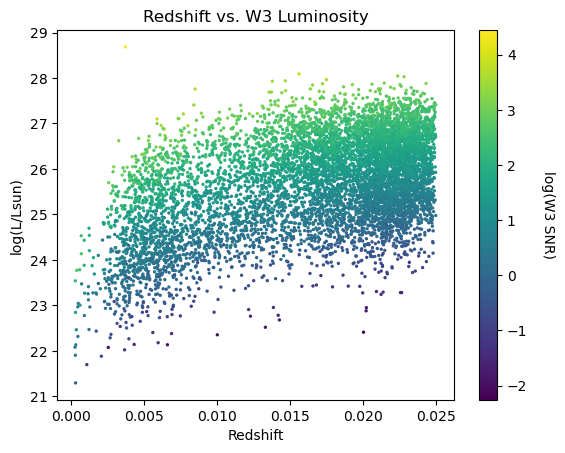

In [15]:
#Plot W3 luminosity vs redshift colored by SNR
W3snr = myTab['w3_nanomaggies']
W3snr_ivar = myTab['w3_nanomaggies_ivar']
W3snr = W3snr*np.sqrt(W3snr_ivar)
ccode = np.log10(W3snr)

plt.scatter(z,np.log10(Lw3),s=2,c=ccode,cmap='viridis')
plt.title('Redshift vs. W3 Luminosity')
plt.ylabel('log(L/Lsun)')
plt.xlabel('Redshift')
cbar = plt.colorbar()
cbar.set_label('log(W3 SNR)',rotation=270,labelpad=20)

C:\Users\EvanB.LAPTOP-8CHCIOMA\AppData\Local\Temp\ipykernel_1984\2938141095.py:3: RuntimeWarning: divide by zero encountered in log10
  ccode = np.log10(size)
C:\Users\EvanB.LAPTOP-8CHCIOMA\AppData\Local\Temp\ipykernel_1984\2938141095.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(z,np.log10(Lw3),s=4,c=ccode,cmap='viridis')
C:\Users\EvanB.LAPTOP-8CHCIOMA\AppData\Local\Temp\ipykernel_1984\2938141095.py:5: RuntimeWarning: invalid value encountered in log10
  plt.scatter(z,np.log10(Lw3),s=4,c=ccode,cmap='viridis')


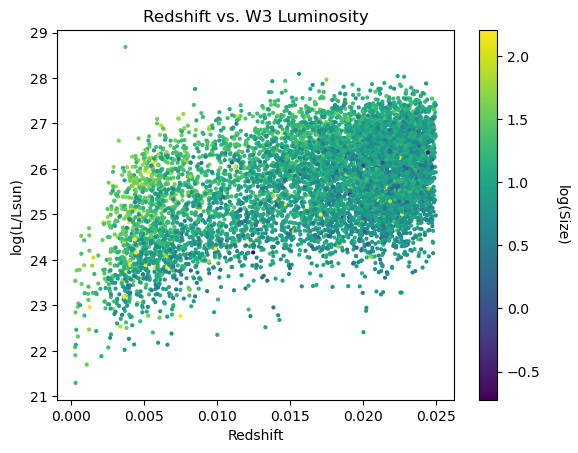

In [28]:
#Plot W3 luminosity vs redshift colored by size
size = myTab['SERSIC_TH50']
ccode = np.log10(size)

plt.scatter(z,np.log10(Lw3),s=4,c=ccode,cmap='viridis')
plt.title('Redshift vs. W3 Luminosity')
plt.ylabel('log(L/Lsun)')
plt.xlabel('Redshift')
cbar = plt.colorbar()
cbar.set_label('log(Size)',rotation=270,labelpad=20)

C:\Users\EvanB.LAPTOP-8CHCIOMA\AppData\Local\Temp\ipykernel_1984\3330751835.py:5: RuntimeWarning: divide by zero encountered in log10
  ccode = np.log10(W3snr)
C:\Users\EvanB.LAPTOP-8CHCIOMA\AppData\Local\Temp\ipykernel_1984\3330751835.py:5: RuntimeWarning: invalid value encountered in log10
  ccode = np.log10(W3snr)
C:\Users\EvanB.LAPTOP-8CHCIOMA\AppData\Local\Temp\ipykernel_1984\3330751835.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(cutz,np.log10(cutLw3),s=2,c=ccode,cmap='viridis')
C:\Users\EvanB.LAPTOP-8CHCIOMA\AppData\Local\Temp\ipykernel_1984\3330751835.py:7: RuntimeWarning: invalid value encountered in log10
  plt.scatter(cutz,np.log10(cutLw3),s=2,c=ccode,cmap='viridis')


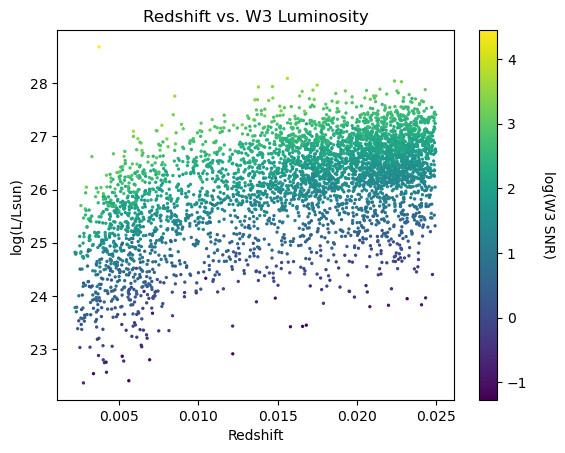

In [24]:
#Plot cut sample W3 luminosity vs redshift colored by SNR
W3snr = cuttab['w3_nanomaggies']
W3snr_ivar = cuttab['w3_nanomaggies_ivar']
W3snr = W3snr*np.sqrt(W3snr_ivar)
ccode = np.log10(W3snr)

plt.scatter(cutz,np.log10(cutLw3),s=2,c=ccode,cmap='viridis')
plt.title('Redshift vs. W3 Luminosity')
plt.ylabel('log(L/Lsun)')
plt.xlabel('Redshift')
cbar = plt.colorbar()
cbar.set_label('log(W3 SNR)',rotation=270,labelpad=20)